In [21]:
import sys
print(sys.executable)
import torch
sys.path.append("../../")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from navrep.envs.navreptrainenv import NavRepTrainEnv
from navrep.envs.roomgen import Room, split_room
from navrep.envs.navreptrainenv import NavRepTrainEnv
from navrep.envs.ianenv import IANEnv
rng = np.random.default_rng(12345)

/home/mads/miniconda3/envs/NavRepEnv/bin/python
Ros was not found, disabled.


In [2]:
room_h = 15
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
r = Room.from_vert(main_room)

In [87]:
room_h = 45
room_w = 35

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
main_room = Room.from_vert(main_room)

axis = 1
corridor_w = 1.5
corridor_num = 5

rooms = []

rooms.append(main_room)
split = main_room.split_room(axis, corridor_w)
rooms=[r for r in split if r.get_area() > 1 and min(r.dim[0],r.dim[1]) > 1.5]


# Creates corridors
for i in range(corridor_num):
    axis = 1 - axis
    corridor_w *= 0.9
    num = len(rooms)
    for i in range(num):
        room = rooms.pop(0)
        split = room.split_room(axis, corridor_w)
        split = [r for r in split if r.get_area() > 2 and min(r.dim[0],r.dim[1]) > 1.5]
        rooms+= split if split else [room]
    r_idx = np.argsort([r.get_area() for r in rooms])#np.arange(len(rooms))
    rooms = [rooms[i] for i in r_idx]
    
# split big rooms
big_rooms = [i for i,r in enumerate(rooms) if r.get_area() > 30 and r.corridor_sides]

removed = []
while big_rooms:
    for i, br_idx in enumerate(big_rooms):
        room = rooms.pop(br_idx-i)
        axis = np.argmax(room.dim)
        #print(room.get_corridor_sides())
        if not any(axis == np.mod(room.get_corridor_sides(),2)):
            #print("flip")
            axis = 1 - axis
        for j in range(4):
            split = room.split_room(axis, 0)
            split_if = [r.get_area() > 2 and min(r.dim[0],r.dim[1]) > 1.5 for r in split]
            if all(split_if):
                rooms+= split
                break
            if j==3:
                removed += [room]
    big_rooms = [i for i,r in enumerate(rooms) if r.get_area() > 30 and r.corridor_sides]
rooms += removed

collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision
collision


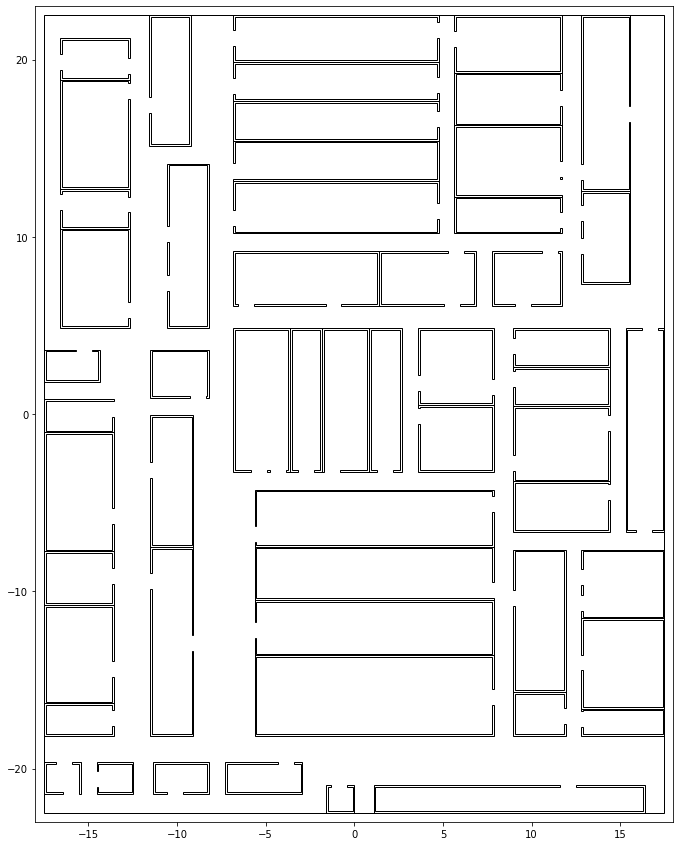

In [88]:
plot_rooms = [main_room]+rooms
fig, ax = plt.subplots(figsize=[15,15])
for r in plot_rooms:
    if r.door:
        for p in r.get_polygons():
            polygon = Polygon(np.array(p), fill=False)
            ax.add_patch(polygon)
            #ax.plot(r.door[0][0][:,0], r.door[0][0][:,1], '.')
    else:
        polygon = Polygon(r.get_vert(), fill=False)
        ax.add_patch(polygon)
    
plt.xlim([-(room_w+1)/2,(room_w+1)/2])
plt.ylim([-(room_h+1)/2,(room_h+1)/2])
ax.set_aspect('equal', 'box')
plt.show()

In [5]:
test_room = Room(6,4,[1,1])

In [6]:
test_room.set_corridor_sides([1,2])
test_room.add_door()
test_room.add_door()
test_room.add_door()

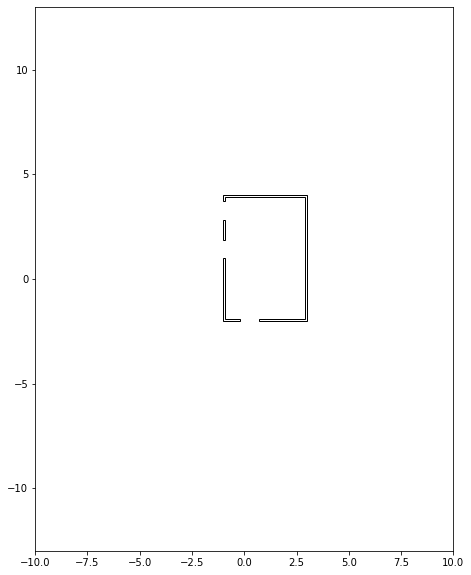

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
for p in test_room.get_polygons():
    polygon = Polygon(p, fill=False)
    ax.add_patch(polygon)
plt.xlim([-10,10])
plt.ylim([-13,13])
ax.set_aspect('equal', 'box')
plt.show()

In [19]:
env = NavRepTrainEnv()
env.reset()
verts = env.soadrl_sim.obstacle_vertices

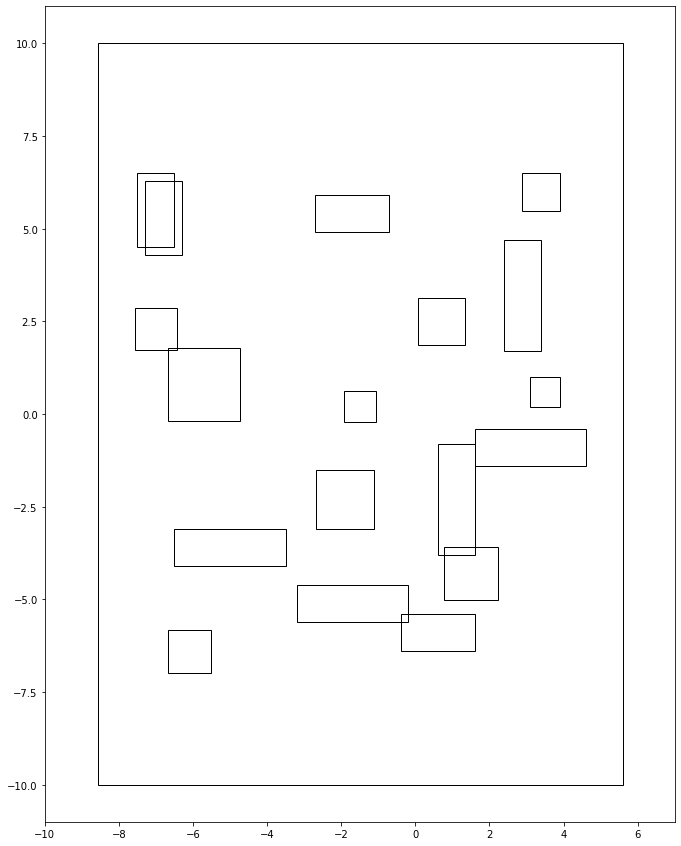

In [67]:
fig, ax = plt.subplots(figsize=[15,15])
for r in verts:
    polygon = Polygon(np.array(r), fill=False)
    ax.add_patch(polygon)

plt.xlim([-10,7])
plt.ylim([-11,11])
ax.set_aspect('equal', 'box')
plt.show()

Loading map definition from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.yaml
Map definition found. Loading map from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.pgm
Agentstate loaded from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/pyIA/scenarios/irosasl_office_j2.pickle
Loading map definition from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.yaml
Map definition found. Loading map from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.pgm
Creating Raytracer
Creating PyOmap
Creating PyRayMarching
Creating virtual Peppers
calculating TSDF
TSDF calculation: 3.0917308229982154s
0.1599999964237213
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


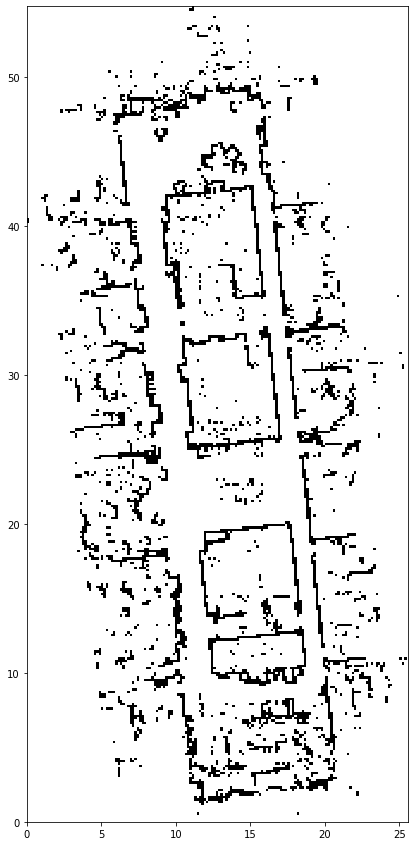

In [61]:
envIAN = IANEnv()
envIAN.reset()
map2d = envIAN.iarlenv.rlenv.coarse_map2d
a = map2d.occupancy()
print(map2d.resolution())
print(a.astype(int))
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(a.astype(int),cmap='Greys',interpolation='none', extent=np.array([0,a.shape[1],0,a.shape[0]])*map2d.resolution())
plt.show()

In [27]:
dir(map2d)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_occupancy',
 'as_closed_obst_vertices',
 'as_closed_obst_vertices_ij',
 'as_coarse_map2d',
 'as_occupied_points_ij',
 'as_sdf',
 'as_sdf_ij',
 'as_tsdf',
 'cdirection_in_field',
 'cset_occupancy',
 'cset_resolution',
 'dijkstra',
 'direction_in_field',
 'distance_transform_2d',
 'distance_transform_2d_ij',
 'empty_like',
 'fastmarch',
 'from_msg',
 'from_scan',
 'ij_to_xy',
 'is_inside_ij',
 'numpy_to_occupancy_grid_msg',
 'occupancy',
 'occupancy_T',
 'old_is_inside_ij',
 'old_render_agents_in_lidar',
 'old_xy_to_ij',
 'origin',
 'plot_contours',
 'render_agents_in_lidar',
 'render_agents_in_many_lidars',
 'resolution',
 'seri